In [6]:
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

num_joints = 14
batch_size = 32
gaussian_sigma = 4

# guassian generation
def getGaussianMap(joint = (16, 16), heat_size = 128, sigma = 2):
    # by default, the function returns a gaussian map with range [0, 1] of typr float32
    heatmap = np.zeros((heat_size, heat_size),dtype=np.float32)
    tmp_size = sigma * 3
    ul = [int(joint[0] - tmp_size), int(joint[1] - tmp_size)]
    br = [int(joint[0] + tmp_size + 1), int(joint[1] + tmp_size + 1)]
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * (sigma ** 2)))
    g.shape
    # usable gaussian range
    g_x = max(0, -ul[0]), min(br[0], heat_size) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], heat_size) - ul[1]
    # image range
    img_x = max(0, ul[0]), min(br[0], heat_size)
    img_y = max(0, ul[1]), min(br[1], heat_size)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
    """
    heatmap *= 255
    heatmap = heatmap.astype(np.uint8)
    cv2.imshow("debug", heatmap)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    """
    return heatmap

# read annotations
annotations = loadmat("./dataset/lsp/joints.mat")
label = annotations["joints"].swapaxes(0, 2)    # shape (3, 14, 2000) -> (2000, 14, 3)

# read images
data = np.zeros([2000, 256, 256, 3])
heatmap_set = np.zeros((2000, 128, 128, num_joints), dtype=np.float32)
print("Reading dataset...")
for i in range(2000):
    FileName = "./dataset/lsp/images/im%04d.jpg" % (i + 1)
    img = tf.io.read_file(FileName)
    img = tf.image.decode_image(img)
    img_shape = img.shape
    # Attention here img_shape[0] is height and [1] is width
    label[i, :, 0] *= (256 / img_shape[1])
    label[i, :, 1] *= (256 / img_shape[0])
    data[i] = tf.image.resize(img, [256, 256])
    # generate heatmap set
    for j in range(num_joints):
        _joint = (label[i, j, 0:2] // 2).astype(np.uint16)
        # print(_joint)
        heatmap_set[i, :, :, j] = getGaussianMap(joint = _joint, heat_size = 128, sigma = gaussian_sigma)
    # print status
    if not i%(2000//80):
        print(">", end='')

# dataset
print("\nGenerating training and testing data batches...")
train_dataset = tf.data.Dataset.from_tensor_slices((data[0:1000], heatmap_set[0:1000]))
test_dataset = tf.data.Dataset.from_tensor_slices((data[1000:-1], heatmap_set[1000:-1]))


Reading dataset...
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Generating training and testing data batches...


In [64]:
import cv2

print(len(data))
print(len(train_dataset))
print(data.shape)

index = 5
image = data[index].astype(np.uint8)
print(image.shape)

cv2.imshow("test", image)
cv2.waitKey(0)


print(label.shape)
skeleton = label[index].astype(np.uint8)
print(skeleton[0])

for i in range(14):
    cv2.circle(image, center=tuple(skeleton[i][0:2]), radius=2, color=(0, 255, 0), thickness=2)
    # draw the lines
    for j in ((13, 12), (12, 8), (12, 9), (8, 7), (7, 6), (9, 10), (10, 11), (2, 3), (2, 1), (1, 0), (3, 4), (4, 5)):
        cv2.line(image, tuple(skeleton[j[0]][0:2]), tuple(skeleton[j[1]][0:2]), color=(0, 0, 255), thickness=1)
    # solve the mid point of the hips
    cv2.line(image, tuple(skeleton[12][0:2]), tuple(skeleton[2][0:2] // 2 + skeleton[3][0:2] // 2), color=(0, 0, 255), thickness=1)

image = image[:,:,::-1]
cv2.imshow("test", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite("test2.jpg", image)

2000
1000
(2000, 256, 256, 3)
(256, 256, 3)
(2000, 14, 3)
[ 56 210   0]


True

In [1]:
import torch
import numpy as np
import os
import scipy.io
from PIL import Image
from torchvision.transforms import *
from torch.utils.data import DataLoader

def standardize_label(label, orim):  #保证了原图像的坐标的准确
    label_std = []
    for idx, _ in enumerate(label):
        labelX = label[idx][0] / orim.size[0]  #x的值除于原始图像的宽
        labelY = label[idx][1] / orim.size[1]  #y的值除于原始图像的高
        label_std.append([labelX, labelY])
    label_std = np.array(label_std)
    # print(label_std)
    return label_std

class PoseImageDataset(torch.utils.data.Dataset):
    def __init__(self, transforms, imagespath='', labelsfilepath=''):

        imgs_list = sorted(os.listdir(os.path.join(imagespath)))  # 获得文件夹内的图片的名称列表
        self.filenames = imgs_list

        #将注释文件加载到矩阵中
        self.annotationmat = scipy.io.loadmat(labelsfilepath)
        # print(self.annotationmat) #加载.mat文件的数据

        joints = self.annotationmat['joints']
        # print(joints) # 只加载'joints'键的数据
        # print(joints.shape) # (3, 14, 2000)

        joints = np.swapaxes(joints, 2, 0)
        """
        print(joints)
        将0轴和2轴转换，使[ 29.74645941 143.34544031   0.        ]就为第一张图片的x轴和y轴以及二进制的值
        [[[ 29.74645941 143.34544031   0.        ]
          [ 30.5501068  117.22690013   0.        ]
          [ 28.94281202  84.67918082   0.        ]
          ...
        """

        labels = []
        images = []
        origin_image_size = []

        for file_idx, file_name in enumerate(imgs_list):
            fn = imgs_list[file_idx]
            orim = Image.open(os.path.join(imagespath,fn))
            origin_image_size.append(orim.size)
            # print(orim)   # Image.open根据拼接的路径获取图像信息

            # print(self.transforms)
            image1 = transforms(orim)  #将图像信息归一化
            # print(image1.shape)

            label = joints[file_idx]
            # print(label)

            #standardizing标准化
            label = standardize_label(label, orim)
            # print(label)

            label = torch.from_numpy(label)  # torch.from_numpy()方法把数组转换成张量，且二者共享内存，对张量进行修改比如重新赋值，那么原始数组也会相应发生改变。
            label1 = label.type(torch.FloatTensor)

            images.append(image1)
            labels.append(label1)

        self.images = images
        self.labels = labels
        self.orim_size = origin_image_size

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx], self.orim_size[idx]

    def __len__(self):
        return len(self.filenames)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 优先使用显卡
print(f"using {device}")

image_path = './dataset/lsp/images'
labels_file_path = './dataset/lsp/joints.mat'
image_size = 256
batch_size = 32
transforms = Compose([
    Resize((image_size,image_size)),
    ToTensor(),  #张量化
    #ToTensor()能够把灰度范围从0-255变换到0-1之间，
    # 而transform.Normalize()则把0-1变换到(-1,1).具体地说，对每个通道而言
    Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

#加载自己的数据集
dataset = PoseImageDataset(transforms, image_path, labels_file_path)
# print(dataset.images.shape)  #(2000, 14, 3)

#数据集划分
total = len(dataset)
print(total)
train_size, test_size = int(total * 0.5), int(total * 0.5)
lengths = [train_size, test_size]
train_dataset, test_dataset = torch.utils.data.dataset.random_split(dataset, lengths)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

using cuda
2000


torch.Size([14, 2])
tensor([0.2373, 0.6437])
[ 60.75985  97.78738 141.47984 161.47472 184.43178 211.83214  87.41967
 117.04169 147.40425 180.72902 168.88022 137.7771  165.91801 174.06407]
[164.77928  133.18616  126.09382  131.25188  166.0688   202.17525
  84.829315  77.73698   71.2894    96.43495  123.514786 128.02809
  78.38174   52.59142 ]


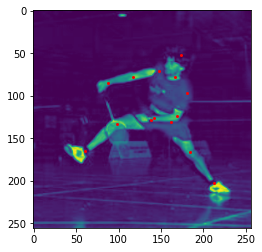

In [52]:
import matplotlib.pyplot as plt

# dataiter = iter(train_dataloader)
# print(len(dataiter.next()))
# images, labels, int_labels= dataiter.next()
img = images[0]
img = img.numpy()
img = np.transpose(img, (1, 2, 0))
img = img[:,:,-1::]

plt.figure()
print(labels[0].shape)
print(labels[0][0])
x = [labels[0][i][0] * 256 for i in range(14)]
y = [labels[0][i][1] * 256 for i in range(14)]
print(np.array(x))
print(np.array(y))
plt.scatter(np.array(x), np.array(y), color = 'red', s = 4)
# print(len(int_labels[0]))
plt.imshow(img)

In [1]:
from model import BlazePose
model = BlazePose()
print(model)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class h_sigmoid(nn.Module):
    def __init__(self):
        super(h_sigmoid, self).__init__()

    def forward(self, x):
        return F.relu6(x + 3.) / 6.


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)


class SwishLinear(nn.Module):
    def __init__(self, inp, oup):
        super(SwishLinear, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(inp, oup),
            nn.BatchNorm1d(oup),
        )

    def forward(self, x):
        return self.linear(x)


class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view((x.size(0),)+self.shape)


class SEModule(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            h_sigmoid()
            # nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class Identity(nn.Module):
    def __init__(self, channel):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class BlazeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3):
        super(BlazeBlock, self).__init__()
        self.use_pooling = stride == 2
        self.channel_pad = out_channels - in_channels

        if self.use_pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            padding = 0
        else:
            padding = 1

        self.depth_conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride,
                                    padding=padding, groups=in_channels)
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU6(inplace=True)

    def forward(self, x):
        if self.use_pooling:
            conv_input = F.pad(x, [0, 1, 0, 1], "constant", 0)
            x = self.pool(x)
        else:
            conv_input = x

        conv_out = self.depth_conv(conv_input)
        conv_out = self.pointwise_conv(conv_out)

        if self.channel_pad > 0:
            x = F.pad(x, [0, 0, 0, 0, 0, self.channel_pad], "constant", 0)

        return self.relu(conv_out + x)


class MobileBottleneck(nn.Module):
    def __init__(self, inp, oup, kernel, stride, exp, se=False, nl='RE'):
        super(MobileBottleneck, self).__init__()
        assert stride in [1, 2]
        assert kernel in [3, 5]
        padding = (kernel - 1) // 2
        self.use_res_connect = stride == 1 and inp == oup

        conv_layer = nn.Conv2d
        norm_layer = nn.BatchNorm2d
        if nl == 'RE':
            nlin_layer = nn.ReLU6 # or ReLU
        elif nl == 'HS':
            nlin_layer = h_swish
        else:
            raise NotImplementedError
        if se:
            SELayer = SEModule
        else:
            SELayer = Identity

        self.conv = nn.Sequential(
            # pw
            conv_layer(inp, exp, 1, 1, 0, bias=False),
            norm_layer(exp),
            nlin_layer(inplace=True),
            # dw
            conv_layer(exp, exp, kernel, stride, padding, groups=exp, bias=False),
            norm_layer(exp),
            SELayer(exp),
            nlin_layer(inplace=True),
            # pw-linear
            conv_layer(exp, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class BlazePose(nn.Module):
    def __init__(self, num_keypoints: int):
        super(BlazePose, self).__init__()

        self.num_keypoints = num_keypoints

        # stem layers
        self.conv1 = nn.Sequential(
                nn.Conv2d(3, 16, 3, 2, 1, bias=False),
                nn.BatchNorm2d(16),
                h_swish()
                )
        
        # MobileBottleneck: input:(inp, oup, k, s, exp, se, li)
        self.conv2_b1 = MobileBottleneck(16, 16, 3, 1, 72, False, 'RE')
        self.conv3_b1 = MobileBottleneck(32, 32, 5, 1, 120, True, 'RE')
        self.conv4_b1 = MobileBottleneck(64, 64, 3, 1, 200, False, 'HS')
        self.conv4_b2 = MobileBottleneck(64, 64, 3, 1, 184, False, 'HS')
        self.conv5_b1 = MobileBottleneck(128, 128, 3, 1, 480, True, 'HS')
        self.conv5_b2 = MobileBottleneck(128, 128, 3, 1, 672, True, 'HS')
        self.conv6_b1 = MobileBottleneck(192, 192, 5, 1, 960, True, 'HS')

        # blaze blocks
        self.conv2 = BlazeBlock(16, 16, 1)
        self.conv3 = BlazeBlock(16, 32, 2)
        self.conv4 = BlazeBlock(32, 64, 2)
        self.conv5 = BlazeBlock(64, 128, 2)
        self.conv6 = BlazeBlock(128, 192, 2)
        
        self.conv7_ = nn.Sequential(
                nn.Conv2d(192, 32, 3, 1, 1, bias=False),
                nn.BatchNorm2d(32),
                h_swish()
                )
        self.conv8_ = nn.Sequential(
                nn.Conv2d(128, 32, 3, 1, 1, bias=False),
                nn.BatchNorm2d(32),
                h_swish()
                )
        self.conv9_ = nn.Sequential(
                nn.Conv2d(64, 32, 3, 1, 1, bias=False),
                nn.BatchNorm2d(32),
                h_swish()
                )
        
        # up sample layer
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True)

        # last several layers
        self.conv11 = nn.Sequential(
            nn.Conv2d(32, self.num_keypoints, 1, 1, 0, bias=False),
            nn.Sigmoid()
            )
        
    def forward(self, x):

        # stem layers
        x = self.conv1(x)
        # dw and pw like mobilenet
        x = self.conv2(x)
        x = self.conv2_b1(x)
        # blaze blocks
        y0 = self.conv3(x)
        y0 = self.conv3_b1(y0)
        y1 = self.conv4(y0)
        y1 = self.conv4_b1(y1)
        y1 = self.conv4_b2(y1)
        y2 = self.conv5(y1)
        y2 = self.conv5_b1(y2)
        y2 = self.conv5_b2(y2)
        y3 = self.conv6(y2)
        y3 = self.conv6_b1(y3)
        
        # get heat map
        x3 = self.conv7_(y3)
        x2 = self.conv8_(y2) + self.upsample2(x3)
        x1 = self.conv9_(y1) + self.upsample1(x2)
        x0 = y0 + self.upsample0(x1)
        heatmap = self.conv11(x0) # => heatmap

        return heatmap


    def _initialize_weights(self):
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


# model = BlazePose(14).to(device)
# print(model)
from torchsummaryX import summary
dummy_input = torch.rand(8,3,256,256)
model = BlazePose(28)
profile = summary(model,dummy_input)

                                                   Kernel Shape  \
Layer                                                             
0_conv1.Conv2d_0                                  [3, 16, 3, 3]   
1_conv1.BatchNorm2d_1                                      [16]   
2_conv1.2.h_sigmoid_sigmoid                                   -   
3_conv2.Conv2d_depth_conv                         [1, 16, 3, 3]   
4_conv2.Conv2d_pointwise_conv                    [16, 16, 1, 1]   
5_conv2.ReLU6_relu                                            -   
6_conv2_b1.conv.Conv2d_0                         [16, 72, 1, 1]   
7_conv2_b1.conv.BatchNorm2d_1                              [72]   
8_conv2_b1.conv.ReLU6_2                                       -   
9_conv2_b1.conv.Conv2d_3                          [1, 72, 3, 3]   
10_conv2_b1.conv.BatchNorm2d_4                             [72]   
11_conv2_b1.conv.Identity_5                                   -   
12_conv2_b1.conv.ReLU6_6                                      

C:\Users\Lodada\AppData\Roaming\Python\Python37\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


In [2]:
# dummy_input = torch.rand(32,3,256,256).to(device)
predict  = model(dummy_input)
print(predict.shape)

torch.Size([8, 28, 64, 64])


In [3]:
from core.inference import get_multi_stage_outputs
from core.inference import aggregate_results

ModuleNotFoundError: No module named 'core'

In [4]:
torch.save(model, "BlazePose.model")

In [11]:
mobile_bottle_neck1 = MobileBottleneck(16, 16, 3, 1, 72, False, 'RE')
print(mobile_bottle_neck1)
torch.save(mobile_bottle_neck1, "model/mobile_bottle_neck1.model")

mobile_bottle_neck2 = MobileBottleneck(32, 32, 5, 1, 120, True, 'RE')
print(mobile_bottle_neck2)
torch.save(mobile_bottle_neck2, "model/mobile_bottle_neck2.model")

mobile_bottle_neck3 = MobileBottleneck(64, 64, 3, 1, 200, False, 'HS')
print(mobile_bottle_neck3)
torch.save(mobile_bottle_neck3, "model/mobile_bottle_neck3.model")

mobile_bottle_neck4 = MobileBottleneck(64, 64, 3, 1, 184, False, 'HS')
print(mobile_bottle_neck4)
torch.save(mobile_bottle_neck4, "model/mobile_bottle_neck4.model")

mobile_bottle_neck5 = MobileBottleneck(128, 128, 3, 1, 480, True, 'HS')
print(mobile_bottle_neck5)
torch.save(mobile_bottle_neck5, "model/mobile_bottle_neck5.model")

mobile_bottle_neck6 = MobileBottleneck(128, 128, 3, 1, 672, True, 'HS')
print(mobile_bottle_neck6)
torch.save(mobile_bottle_neck6, "model/mobile_bottle_neck6.model")

mobile_bottle_neck7 = MobileBottleneck(192, 192, 5, 1, 960, True, 'HS')
print(mobile_bottle_neck7)
torch.save(mobile_bottle_neck7, "model/mobile_bottle_neck7.model")


MobileBottleneck(
  (conv): Sequential(
    (0): Conv2d(16, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
    (3): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72, bias=False)
    (4): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Identity()
    (6): ReLU6(inplace=True)
    (7): Conv2d(72, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
MobileBottleneck(
  (conv): Sequential(
    (0): Conv2d(32, 120, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
    (3): Conv2d(120, 120, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=120, bias=False)
    (4): BatchNorm2d(120, eps=1e-05, 

In [12]:
blaze_block1 = BlazeBlock(16, 16, 1)
print(blaze_block1)
torch.save(blaze_block1, "model/blaze_block1.model")

blaze_block2 = BlazeBlock(16, 32, 2)
print(blaze_block2)
torch.save(blaze_block2, "model/blaze_block2.model")

blaze_block3 = BlazeBlock(32, 64, 2)
print(blaze_block3)
torch.save(blaze_block3, "model/blaze_block3.model")

blaze_block4 = BlazeBlock(64, 128, 2)
print(blaze_block4)
torch.save(blaze_block4, "model/blaze_block4.model")

blaze_block5 = BlazeBlock(128, 192, 2)
print(blaze_block5)
torch.save(blaze_block5, "model/blaze_block5.model")

BlazeBlock(
  (depth_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
  (pointwise_conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU6(inplace=True)
)
BlazeBlock(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (depth_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), groups=16)
  (pointwise_conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU6(inplace=True)
)
BlazeBlock(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (depth_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), groups=32)
  (pointwise_conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU6(inplace=True)
)
BlazeBlock(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (depth_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), groups=64)
  (pointwise_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 

In [ ]:
SE_model1 = SEModule(120)
print(SE_model1)
torch.save(SE_model1, "model/SE_model1.model")


In [4]:
block2 = 160 + 41 * 16 + 73 * 32 + 137 * 64 + 201 * 128

block1 = (72*16+72+72+72*9+144+15*72+32) + (120*32+240+120*25+240+64+32*120)
+ (200*64+400+200*9+400+63*200+128) + (184*64+184*2+184*9+368+64*184+128)
+ (480*128+960+480*9+960+128*480+256) + (128*672+1344+1344+672*9+128*672+256)
+ (960*192+1920+1920+960*25+192*960+384)
block3 = 16*27+32+32*192*9+64+17*32+32*128*9+64+32*64*9+64
print(block1 + block2 + block3)

163864


In [6]:
def train():
    model.train()
    loss_value = 0
    for tmp, (images, labels, _) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)  #方便用于gpu
        print(labels.shape)
        print(images.shape)
        
        predict = model(images)  # 把图像数据放进model里
        print(predict.shape)
        print(labels.shape)
        
        predict = predict.view(labels.shape)

        loss_value = lossFunction(predict, labels)  # 将标签和图像数据同时放入

        # 反向传播
        optimizer.zero_grad()  # 梯度置零，也就是把loss关于weight的导数变成0.
        loss_value.backward()
        optimizer.step()

        if tmp > 0:
            if (tmp % 10) == 0:
                print('checkpoint guardado' + str(tmp))
                torch.save(model.state_dict(), './chpcurrent_HourGlass.chp')

    return loss_value.item()

def test():
    model.eval()
    test_loss_total = 0

    images_accuracy = []

    for images, labels, orim_size in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        predict = model(images)  # 把图像数据放进model里

        predict = predict.view(labels.shape)  #将预测的关节点坐标整理成原始坐标的形状

        for idx, _ in enumerate(labels):
            image_accuracy = Accuracy.accuracy(predict[idx], labels[idx], image_size)
            images_accuracy.append(image_accuracy)

        loss_value = lossFunction(predict, labels)  # 将标签和图像数据同时放入

        test_loss_total += loss_value


    accuracy = sum(images_accuracy) / len(images_accuracy)  #batch的准确率
    test_loss_total /= len(test_dataset)

    print("准确率：", accuracy)
    return test_loss_total, accuracy

In [7]:
test_loss, accuracy = [], []

EPOCHS = 1
# 批训练EPOCHS
for epoch in range(1, EPOCHS+1):

    train_loss = train()  #训练

    test_loss_, accuracy_ = test()   #测试
    print(f"第{epoch}/{EPOCHS}次训练，训练损失值为{train_loss}, 测试损失值为{test_loss_},测试准确率为{accuracy_}")

    test_loss1 = test_loss_.detach().numpy()
    test_loss.append(test_loss1)
    accuracy.append(accuracy_)

torch.Size([32, 14, 2])
torch.Size([32, 3, 256, 256])


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 8.00 GiB total capacity; 5.72 GiB already allocated; 0 bytes free; 5.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF